In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(color_codes=True)
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
XAVIER= tf.contrib.layers.xavier_initializer(uniform = True)
CONST = tf.constant_initializer(0.0)
NORMAL = tf.random_normal_initializer(mean = 0.0, stddev = 0.5)
def image_print(image):
    if image.ndim == 1:
        image = np.reshape(image, [28, 28])
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def linear(input, output_dim, scope=None):
    '''
    operation :
        input :
            matrixes(a*b) dim = 2
        input.get_shape() => (a, b)
        input.get_shape()[1] => b
        w => b*output_dim
        tf.matmul(input, w ) => a * output_dim
        b= > output_dim
    return :
        matrixes(a*output_dim) 
    '''
    
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=XAVIER)
        b = tf.get_variable('b', [output_dim], initializer=NORMAL)
        return tf.matmul(input, w) + b

def get_shape(tensor):
    return tensor.get_shape().as_list()

def clip(x, vmin = 1e-10, vmax = 1-1e-10):
    return tf.clip_by_value(x, clip_value_max= vmax, clip_value_min= vmin)

def change_var(sess, var, discount):
    new_var = sess.run(var)*discount
    sess.run(tf.assign(var, new_var))

def print_keys(string):
    i=0
    while True:
        try:
            print("{} : {}".format(tf.get_collection(string)[i].op.name, 
                                   get_shape(tf.get_collection(string)[i])))
            i+=1
        except IndexError:
            break 
def mnist_load():
    mnist = input_data.read_data_sets('../MNIST_data/', one_hot = True)
    trX = mnist.train.images
    trY = mnist.train.labels
    teX = mnist.test.images
    teY = mnist.test.labels
    vaX = mnist.validation.images
    vaY = mnist.validation.labels
    
    return trX, vaX, teX, trY, vaY, teY

In [3]:
trX, vaX, teX, trY, vaY, teY = mnist_load()

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
batch_size = 100
batch_num = 550
epoch = 20
rnn_size = 100

In [5]:
x = tf.placeholder(tf.float32, shape= [None, 27, 28])
y = tf.placeholder(tf.float32, shape= [None, 27, 28])

x_t = tf.transpose(x, [1,0,2])
x_r = tf.reshape(x_t, [-1, 28])
x_split = tf.split(x_r, 27, axis = 0)

with tf.variable_scope("rnn") as scope:
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_size)
    wrapped_cell = tf.contrib.rnn.OutputProjectionWrapper(lstm_cell, 28)
    outputs, states = tf.contrib.rnn.static_rnn(wrapped_cell, x_split, dtype=tf.float32) 

outputs_stack = tf.stack(outputs)
outputs_t = tf.transpose(tf.sigmoid(outputs_stack), [1, 0 , 2])
error = tf.reduce_mean(tf.square(outputs_t-y))
optimizer = tf.train.AdamOptimizer().minimize(error)

# Restore

In [6]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, './save/model')

# Save

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for e in range(epoch):
    index = np.arange(len(trY))
    np.random.shuffle(index)
    trX = trX[index]
    trY = trY[index]
    epoch_loss = 0 
    for batch in range(batch_num):
        train_batch = trX[batch*batch_size:(batch+1)*batch_size]
        train_batch_r = np.reshape(train_batch, [batch_size, 28, 28])
        input_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[:-1], [1,0,2])
        output_batch = np.transpose(np.transpose(train_batch_r, [1, 0, 2])[1:], [1,0,2])
        train_feed_dict = {x : input_batch, y : output_batch}
        _, cost = sess.run([optimizer, error], feed_dict=train_feed_dict)
        epoch_loss += cost
    print('Epoch({}/{}) cost = {}'.format(e+1, epoch, epoch_loss))
saver = tf.train.Saver()
saver.save(sess, './save/model')

Epoch(1/20) cost = 33.14861681684852
Epoch(2/20) cost = 13.669601697474718
Epoch(3/20) cost = 10.972721122205257
Epoch(4/20) cost = 10.040749965235591
Epoch(5/20) cost = 9.544360952451825
Epoch(6/20) cost = 9.207630536518991
Epoch(7/20) cost = 8.95930362213403
Epoch(8/20) cost = 8.76710882410407
Epoch(9/20) cost = 8.596697371453047
Epoch(10/20) cost = 8.4521568659693
Epoch(11/20) cost = 8.31650786101818
Epoch(12/20) cost = 8.199162852019072
Epoch(13/20) cost = 8.097868864424527
Epoch(14/20) cost = 8.000228277407587
Epoch(15/20) cost = 7.910238256677985
Epoch(16/20) cost = 7.826700121164322
Epoch(17/20) cost = 7.7472029365599155
Epoch(18/20) cost = 7.669380282983184
Epoch(19/20) cost = 7.598661393858492
Epoch(20/20) cost = 7.531620247289538


'./save/model'

In [7]:
def image_generator(image, keep_num = 14):
    image_r = np.reshape(image, [28, 28])
    image_restore = np.zeros((28,28))
    for i in range(keep_num):
        for j in range(28):
            image_restore[i][j] = image_r[i][j]
    for i in range(keep_num, 28):
        restored = sess.run(outputs_t, feed_dict = {x : np.reshape(image_restore[:-1], [1, 27, 28])}) 
        for j in range(28):
            image_restore[i][j] = restored[0][i-1][j]
    return image_restore

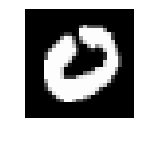

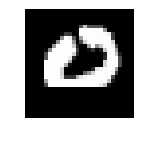

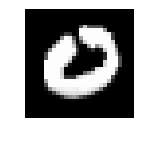

In [14]:
image_sample = np.reshape(teX[25], [28, 28])
keep_row = 20
image_clip = np.zeros((28,28))
for i in range(keep_row):
    for j in range(28):
        image_clip[i][j] = image_sample[i][j]
image_fake = image_generator(image_clip, keep_num=keep_row)
image_print(image_sample)
image_print(image_clip)
image_print(image_fake)